In [10]:
import ROOT
from ROOT import RooFit, RooRealVar, RooFormulaVar, RooGaussian, RooChebychev, RooExponential
from ROOT import RooStats, RooWorkspace, RooProduct, RooAddPdf, RooArgList, RooArgSet
from ROOT import TCanvas, TPad

-------------------------------------------------
p-value(null) 2.4808178189523936e-12
Signifcance  6.906669632291603
-------------------------------------------------


[#1] INFO:ObjectHandling -- RooWorkspace::import(wspace) importing RooAddPdf::model
[#1] INFO:ObjectHandling -- RooWorkspace::import(wspace) importing RooGaussian::sigModel
[#1] INFO:ObjectHandling -- RooWorkspace::import(wspace) importing RooRealVar::mass
[#1] INFO:ObjectHandling -- RooWorkspace::import(wspace) importing RooRealVar::mH
[#1] INFO:ObjectHandling -- RooWorkspace::import(wspace) importing RooRealVar::sigma
[#1] INFO:ObjectHandling -- RooWorkspace::import(wspace) importing RooProduct::fsig
[#1] INFO:ObjectHandling -- RooWorkspace::import(wspace) importing RooRealVar::mu
[#1] INFO:ObjectHandling -- RooWorkspace::import(wspace) importing RooRealVar::ratioSigEff
[#1] INFO:ObjectHandling -- RooWorkspace::import(wspace) importing RooRealVar::fsigExpected
[#1] INFO:ObjectHandling -- RooWorkspace::import(wspace) 

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       46744.24499 Edm =    1.21227208e-07 NCalls =      3
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : 46744.24499
  Edm           : 1.21227208e-07
  Internal parameters:	[     0.1477989008]	
  Internal gradient  :	[  -0.002738355255]	
  Internal covariance matrix:
[[    0.064666673]]]
Info in <Minuit2>: VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 500
Info in <Minuit2>: VariableMetricBuilder    0 - FCN =       46744.24499 Edm =    1.21227208e-07 NCalls =      3
Warning in <Minuit2>: VariableMetricBuilder No improvement in line search
Info in <Minuit2>: VariableMetricBuilder    1 - FCN =       46744.24499 Edm =    1.21227208e-07 NCalls =     14
Info in <Minuit2>: VariableMetricBuilder After Hessian
Info in <Minuit2>: VariableMetricBuilder    2 - FCN =       46744.24499 Edm =   1.220554998e-10

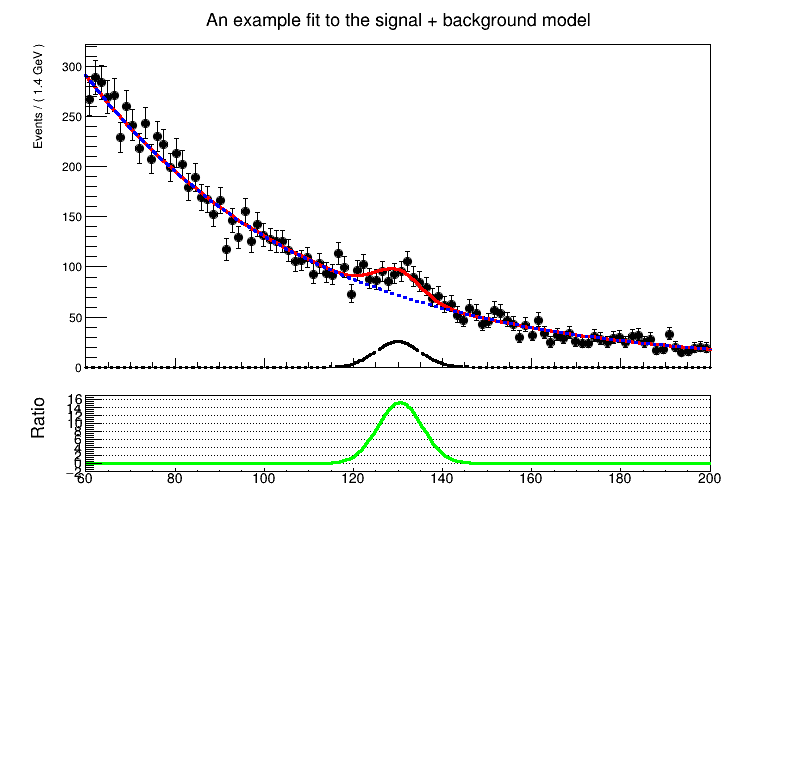

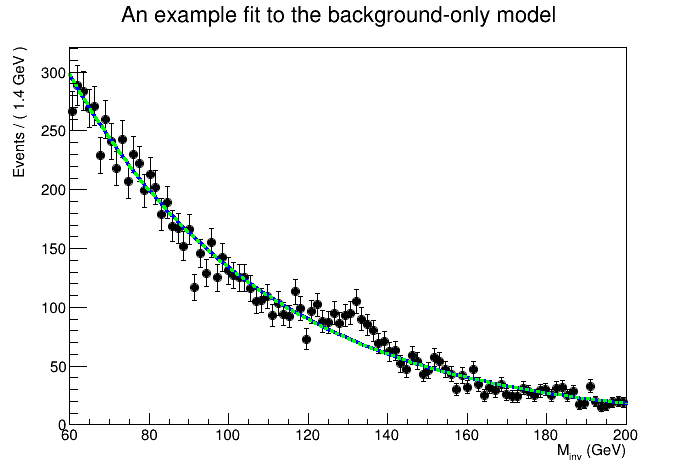

In [11]:
mass = RooRealVar("mass", "M_{inv}", 60, 200, "GeV")

mH = RooRealVar("mH", "Higgs Mass", 130, 90, 160)
sigma = RooRealVar("sigma", "Width of Gaussian", 5., 2, 100)
sigModel = RooGaussian("sigModel", "Signal Model", mass, mH, sigma)

mH.setConstant()
sigma.setConstant()

alpha = RooRealVar("alpha", "alpha", -0.02, -1, 0)
qcdModel = RooExponential("qcdModel", "QCD Model", mass, alpha)

alpha.setConstant()

fsigExpected = RooRealVar("fsigExpected", "expected fraction of signal events", .02, 0., 1)
fsigExpected.setConstant()

mu = RooRealVar("mu", "signal strength in units of SM expectation", 1, 0., 2)

ratioSigEff = RooRealVar("ratioSigEff", "ratio of signal efficiency to nominal signal efficiency", 1., 0., 2)
ratioSigEff.setConstant()

fsig = RooProduct("fsig", "fraction of signal events", RooArgList(mu, ratioSigEff, fsigExpected))

model = RooAddPdf("model", "sig+qcd background shapes", RooArgList(sigModel, qcdModel), fsig)

data = model.generate(RooArgSet(mass), 10000)

wspace = RooWorkspace("wspace")

getattr(wspace, 'import')(model)
getattr(wspace, 'import')(data, RooFit.Rename("data"))

model = ROOT.RooStats.ModelConfig()
model.SetWorkspace(wspace)
model.SetPdf("model")

prof = RooStats.ProfileLikelihoodCalculator()
prof.SetData(wspace.data("data"))

mu = wspace.var("mu")
poi = RooArgSet(mu)
nullParams = RooArgSet(poi.snapshot())
nullParams.setRealValue("mu", 0)

prof.SetModel(model)

prof.SetNullParameters(nullParams)

hypo = prof.GetHypoTest()

# mu = wspace.var("mu")
# poi = RooArgSet(mu)

# model = ROOT.RooStats.ModelConfig()
# model.SetWorkspace(wspace)
# model.SetPdf("model")
# model.SetParametersOfInterest(poi)
# model.SetSnapshot(poi)

# bmodel = ROOT.RooStats.ModelConfig()
# bmodel.SetWorkspace(wspace)
# bmodel.SetPdf("qcdModel")
# bmodel.SetParametersOfInterest(poi)
# bmodel.SetSnapshot(poi)

# data = wspace.data("data")

# asym = RooStats.AsymptoticCalculator(data, model, bmodel)

# hypo = asym.GetHypoTest()

print("-------------------------------------------------")
print("p-value(null)", hypo.NullPValue())
print("Signifcance ", hypo.Significance())
print("-------------------------------------------------\n\n")

model = wspace.pdf("model")
sigModel = wspace.pdf("sigModel")
qcdModel = wspace.pdf("qcdModel")

mu = wspace.var("mu")
mass = wspace.var("mass")
data = wspace.data("data")

mu.setConstant(ROOT.kFALSE)

model.fitTo(data)

ratio = RooFormulaVar("ratio", "sigModel/qcdModel", RooArgList(sigModel, qcdModel))


# c1 = TCanvas()
c1 = TCanvas("canvas", "Signal Mass Variations", 800, 800)
c1.Divide(1, 2)
c1.cd(1)

pad1 = TPad("pad1", "pad1", 0, 0, 1, 1.)
pad1.SetBottomMargin(0.03)
pad1.Draw()        
pad1.cd()

frame1 = mass.frame()
data.plotOn(frame1)
model.plotOn(frame1, RooFit.LineColor(ROOT.kRed))
model.plotOn(frame1, RooFit.Components(RooArgSet(sigModel)), RooFit.LineStyle(ROOT.kDashed), RooFit.LineColor(ROOT.kBlack))
model.plotOn(frame1, RooFit.Components(RooArgSet(qcdModel)), RooFit.LineStyle(ROOT.kDashed), RooFit.LineColor(ROOT.kBlue))

frame1.SetTitle("An example fit to the signal + background model")
frame1.GetXaxis().SetLabelOffset(999)
frame1.Draw()

c1.cd(2)
pad1_ = TPad("pad1_", "pad1_", 0, 0.7, 1, 1.)
pad1_.SetTopMargin(0.02)
pad1_.SetBottomMargin(0.3)
pad1_.SetGridy()
pad1_.Draw()
pad1_.cd()

frame1_ = mass.frame()
ratio.plotOn(frame1_, RooFit.LineColor(ROOT.kGreen))
# frame1_.GetXaxis().SetTitleOffset(999)
# frame1_.GetXaxis().SetRangeUser(60, 200)
frame1_.GetYaxis().SetRangeUser(-2, 17)
# frame1_.GetYaxis().SetTitleSize(20)
# frame1_.GetYaxis().SetLabelSize(15)
frame1_.SetTitle(" ")

frame1_.GetYaxis().SetTitle("Ratio")
frame1_.GetYaxis().SetTitleSize(20)
frame1_.GetYaxis().SetTitleFont(43)
frame1_.GetYaxis().SetTitleOffset(1.5)
frame1_.GetYaxis().SetLabelFont(43)
frame1_.GetYaxis().SetLabelSize(15)

frame1_.GetXaxis().SetTitle("M_{12}")
frame1_.GetXaxis().SetLabelOffset(0)
frame1_.GetXaxis().SetTitleSize(20)
frame1_.GetXaxis().SetTitleFont(43)
frame1_.GetXaxis().SetTitleOffset(3.5)
frame1_.GetXaxis().SetLabelFont(43)
frame1_.GetXaxis().SetLabelSize(15)

frame1_.Draw()

c1.Draw()

mu.setVal(0)  
mu.setConstant(ROOT.kTRUE) 

model.fitTo(data)

c2 = TCanvas()
frame2 = mass.frame()
data.plotOn(frame2, RooFit.DataError(ROOT.RooAbsData.SumW2))
model.plotOn(frame2)
model.plotOn(frame2, RooFit.Components(RooArgSet(qcdModel)), RooFit.LineStyle(ROOT.kDashed), RooFit.LineColor(ROOT.kGreen))

frame2.SetTitle("An example fit to the background-only model")
frame2.Draw()

c2.Draw()